# Задание 6

In [85]:
import numpy as np
%matplotlib inline
%matplotlib widget
import matplotlib.pyplot as plt
from typing import Callable
import functools
import pandas as pd
from random import uniform as rnd
import scipy.integrate as integrate

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Построение составной КФ Гаусса с N узлами

### Код из [Задания 5](https://github.com/astatochek/Computational_Workshop_4_sem/blob/main/5.1%20New%20Type%20of%20Integrals/note.ipynb)

In [39]:
# полиномы Лежандра (изначально P0 и P1)
legendre_polynomials = [lambda x: 1., lambda x: x]
# функция получения многочлена Лежандра степени n
def get_Legendre(n: int) -> Callable:
    def constructor(f1: Callable, f2: Callable, k: int) -> Callable:
        def func(x: float) -> float:
            return f1(x) * x * (2 * k - 1) / k - f2(x) * (k - 1) / k
        return func
    while len(legendre_polynomials) <= n:
        i = len(legendre_polynomials)
        next_func = constructor(legendre_polynomials[i-1], legendre_polynomials[i-2], i)
        legendre_polynomials.append(next_func)
    return legendre_polynomials[n]
# величина невязки в методе секущих
eps = 1.e-12
# метод секущих
def secant_method(f: Callable, a: float, b: float) -> np.ndarray:
    segments = []
    # функция для получения разбиения отрезка [a, b]
    def get_partition(n: float, a: float, b: float) -> None:
        h = (b - a) / n
        left = a
        for i in range(int(n)):
            right = a + (i + 1) * h
            if f(left) * f(right) < 0:
                segments.append([left, right])
            if f(right) != 0:
                left = right
    # получения разбиения для отрезка [-1, 1] с сохранением результатов в segments
    get_partition(1.e3, a, b)
    # функция для получения случайного числа из интервала (a, b)
    def get_random(a: float, b: float) -> float:
        x = rnd(a, b)
        while x == a or x == b:
            x = rnd(a, b)
        return x
    # сам метод секущих
    def pure_secants(s: list[float]) -> float:
        x0 = s[0]
        x1 = get_random(x0, s[1])
        x2 = x1 - (f(x1) / (f(x1) - f(x0))) * (x1 - x0)
        while abs(x2 - x1) >= eps:
            x2, x1, x0 = x2 - (f(x2) / (f(x2) - f(x1))) * (x2 - x1), x2, x1
        return x2
    # получение корней на сегментах методом секущих
    hubs = np.array([pure_secants(segment) for segment in segments])
    return hubs
# получение коэффициентов КФ Гаусса
def get_gauss_coefficients(hub_list: np.ndarray, n: int) -> np.ndarray:
    Pn1 = get_Legendre(n - 1)
    return np.array([2 * (1 - x**2) / (n * Pn1(x))**2 for x in hub_list])
# вывод коэффициентов и узлов КФ Гаусса степени n
def get_hubs_coefficients(n: int) -> pd.DataFrame:
    dfs = {}
    P = get_Legendre(n)
    hubs = secant_method(P, -1, 1)
    coefficients = get_gauss_coefficients(hubs, n)
    dfs[f"Узлы для N={n}"] = hubs
    dfs[f"Коэффициенты для N={n}"] = coefficients
    return pd.DataFrame(dfs, index=[f"X{i+1}" for i in range(n)])

 ### Реализация составной КФ Гаусса

In [44]:
def composite_gauss(f: Callable, a: float, b: float, n: int, m: int) -> float:
    legendre = get_Legendre(n)
    hubs = secant_method(legendre, -1, 1)
    coefficients = get_gauss_coefficients(hubs, n)
    S = 0
    h = (b - a) / m
    for i in range(m):
        hub_list = np.array([(2*a + h * (t + 2*i+1)) / 2 for t in hubs])
        S += np.sum([coefficients[j] * f(hub_list[j]) for j in range(n)])
    return h * S / 2

### Вычисление $\displaystyle\int_a^b\rho(x)f(x)~dx$ при $\rho(x) = \sqrt{1-x}$, $f(x) = \sin(x)$

In [112]:
n = int(input('Введите число узлов для КФ Гаусса'))
m = int(input('Введите число промежутков деления'))
a = float(input('Введите a'))
b = float(input('Введите b'))

phi = lambda x: np.sqrt(1 - x) * np.sin(x)
# phi = lambda x: x**3 + x**2 + x + 1
Value = composite_gauss(phi, a, b, n, m)
Expected, ExpectedError = integrate.quad(phi, a, b)
print(f'N = {n}, M = {m}, a = {a}, b = {b}')
print('Value:', Value)
print('Expected:', Expected)
print('Error:', abs(Value - Expected))
print(f'(Expected Error: {ExpectedError})')

size = 5
data = {}
BestValue = Value
BestError = abs(Value - Expected)
best_n = n
best_m = m
for j in range(size):
    fragmentation = int(m * (j + 1 + size // 2) / size)
    Errors = []
    for i in range(size):
        degree = int(n * (i + 1 + size // 2) / size)
        val = (Value if n == degree and m == fragmentation else composite_gauss(phi, a, b, degree, fragmentation))
        if abs(val - Expected) < BestError:
            BestValue = val
            BestError = abs(val - Expected)
            best_n = degree
            best_m = fragmentation
        # print(f'M={fragmentation}, N={degree}, Error={abs(val - Expected)}')
        Errors.append(str(abs(val - Expected)))
    data[f'M={fragmentation}'] = [val for val in Errors]
print('Best Case:')
print(f'N = {best_n}, M = {best_m}')
print(f'Value: {BestValue}')
print(f'Error: {BestError}')
df = pd.DataFrame(data, index=[f'N={int(n * (i + 1 + size // 2) / size)}' for i in range(size)])
df

N = 6, M = 100, a = -2.0, b = 1.0
Value: -1.8512133381201918
Expected: -1.8512553511459553
Error: 4.201302576345434e-05
(Expected Error: 2.1413288919802653e-09)
Best Case:
N = 4, M = 140
Value: -1.8512584571150643
Error: 3.1059691090185026e-06


,M=60,M=80,M=100,M=120,M=140
N=3,2.3083587818328866e-05,3.7579620765226807e-05,1.6139267586812167e-05,3.3086031288043216e-06,6.2702550267523804e-06
N=4,4.038922179039339e-05,4.1743532914528814e-05,6.049910279304349e-05,1.3378349006165635e-05,3.1059691090185026e-06
N=6,0.0002522419214365801,3.2851172799608364e-05,4.201302576345434e-05,2.2145418934638172e-05,0.00021859827771164575
N=7,0.00011386495192544643,0.000254376275555801,8.553005422862192e-05,5.240757207802815e-05,3.572006830365737e-05
N=8,0.00020532013091578705,0.0001545855461675405,0.0005659984579824417,0.0005219818146118271,3.918404094593875e-05


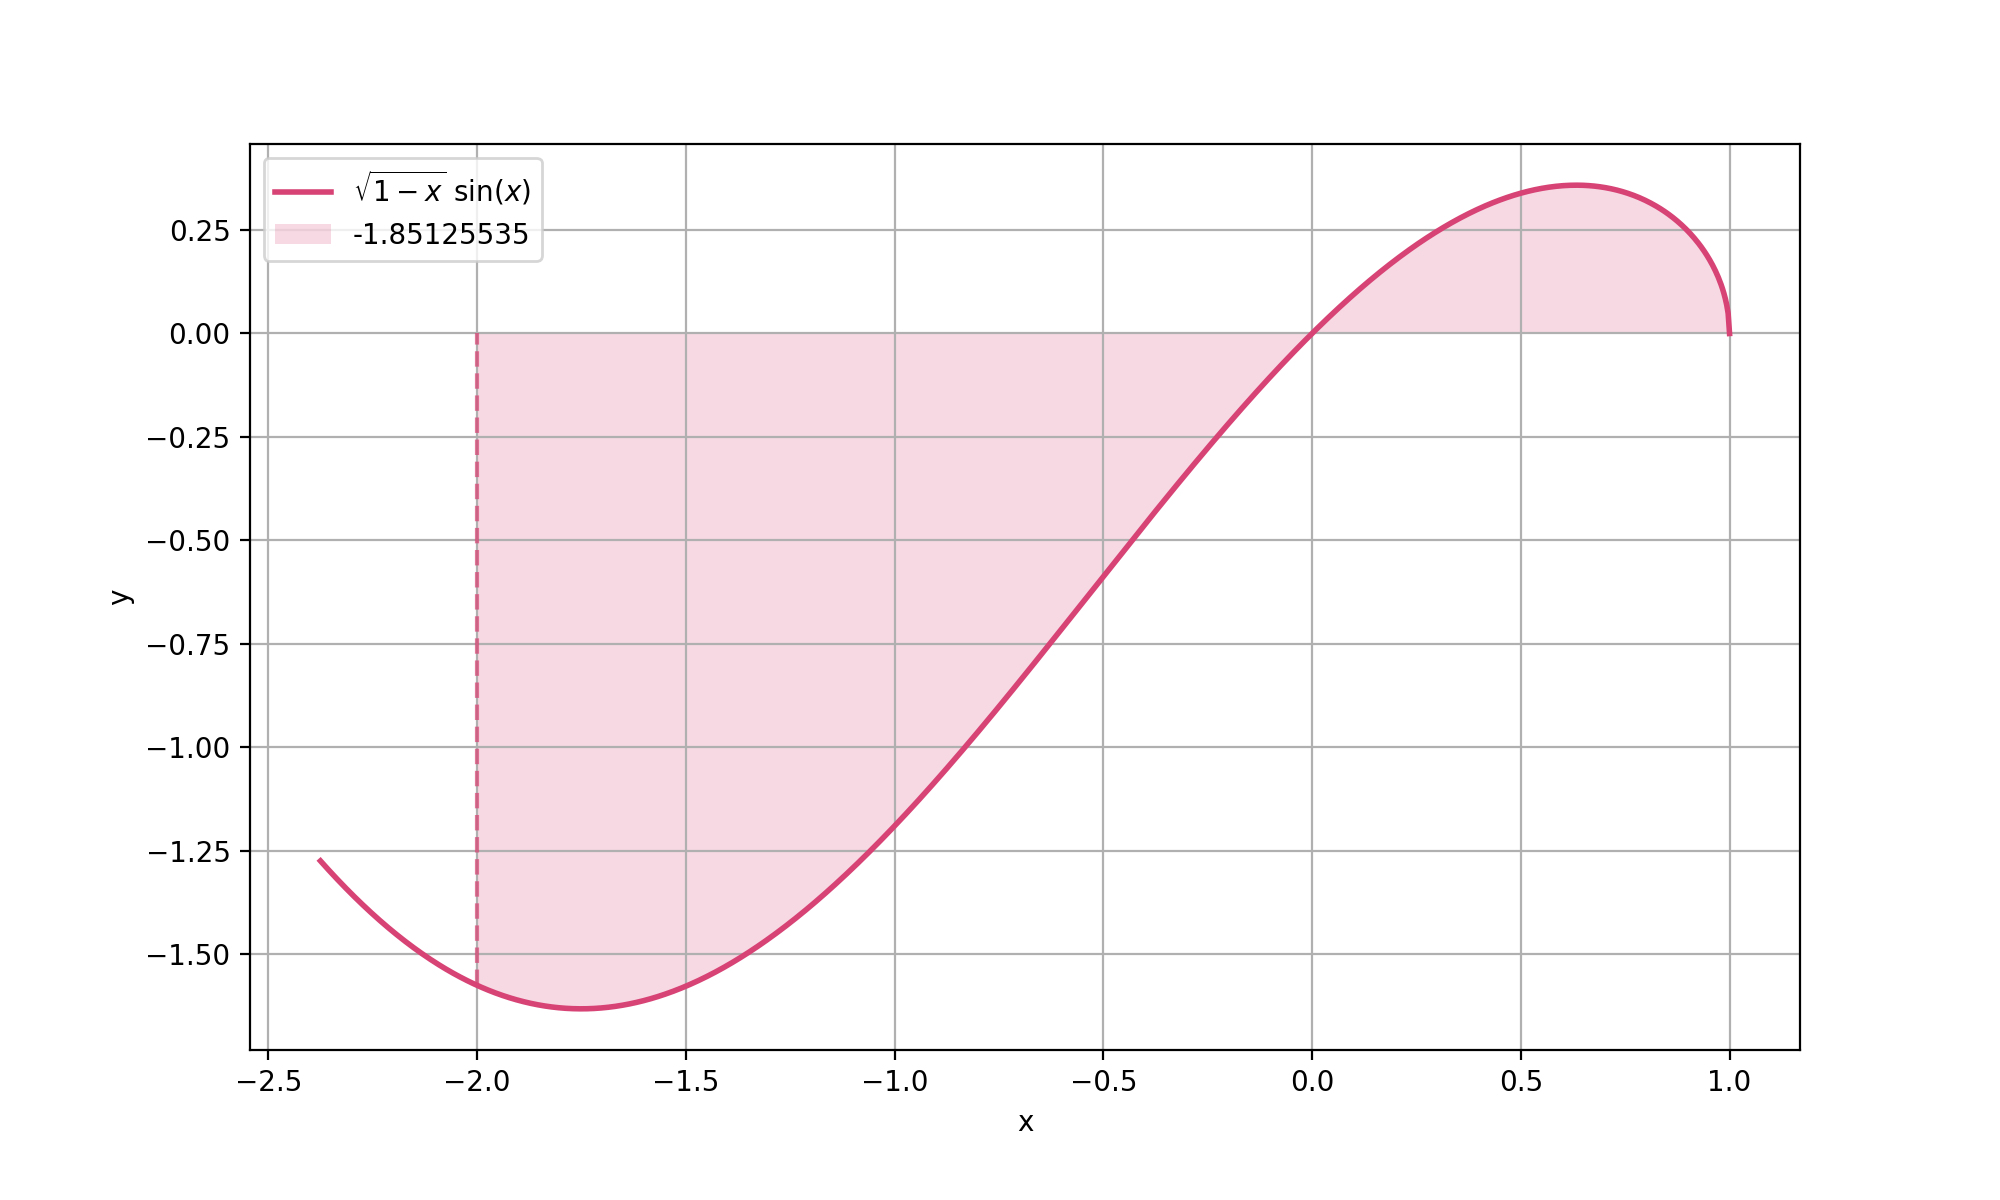

In [113]:
num = 1000
eps = (b - a) / 8
eps_right = eps
if abs(1 - b) < eps:
    eps_right = abs(1 - b)
X = np.linspace(a - eps, b + eps_right, num)
Y = [phi(x) for x in X]
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
ax.plot(X, Y, color='#d74374', linewidth=2, label=r'$\sqrt{1-x}~\sin(x)$')
ax.vlines(a, min(phi(a), 0), max(phi(a), 0), color="#d74374", alpha=0.7, linestyle="--")
ax.vlines(b, min(phi(b), 0), max(phi(b), 0), color="#d74374", alpha=0.7, linestyle="--")
X = [x for x in X if a <= x <= b]
Y = [phi(x) for x in X]
Ox = [0 for _ in X]
ax.fill_between(X, Ox, Y, facecolor='#d74374', alpha=0.2, label=f'{round(Expected, 8)}')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid()
ax.legend()

plt.show()

### Вывод узлов и коэффициентов исходной КФ Гаусса

In [48]:
# n вводится в предыдущем блоке
legendre = get_Legendre(n)
nodes = secant_method(legendre, -1, 1)
coefficients = get_gauss_coefficients(nodes, n)
data = {}
for i in range(n):
    data[f'Node {i+1}'] = {'Nodes': str(nodes[i]), 'Coefficients': str(coefficients[i])}
df = pd.DataFrame(data)
df

,Node 1,Node 2,Node 3,Node 4,Node 5,Node 6
Nodes,-0.9324656532062711,-0.6612101070957845,-0.23861930557801472,0.2386192507967906,0.6612087735000992,0.9324665077639679
Coefficients,0.17139067980458647,0.36075729703049353,0.46791373650750273,0.46791382730847675,0.36076521028504904,0.17137602769030663


# Построение КФ НАСТ с весом

### Нахождение $\mu_0,\mu_1,\dots,\mu_{2N-1}$

In [88]:
@functools.lru_cache(maxsize=10)
def get_mu(n: int, a: float, b: float, rho: Callable) -> np.ndarray:
    mu = [integrate.quad(lambda x: rho(x) * x**i, a, b)[0] for i in range(2*n)]
    return np.array(mu)

### Нахождение коэффициентов для $\omega_N(x) = x^N + a_1x^{N-1} + \dots + a_{N-1}x + a_N$

In [89]:
def get_omega_coefficients(n: int, a: float, b: float, rho: Callable) -> np.ndarray:
    mu = get_mu(n, a, b, rho)
    matrix = np.array([[mu[j] for j in range(i + n - 1, -1 + i, -1)] for i in range(n)])
    col = np.array([-mu[i+n] for i in range(n)])
    return np.linalg.solve(matrix, col)

### Нахождение корней уравнения $\omega_N(x) = 0$

In [90]:
def get_omega_roots(n: int, a: float, b: float, rho: Callable) -> np.ndarray:
    coefficients = get_omega_coefficients(n, a, b, rho)
    omega = lambda x: x**n + sum([coefficients[i] * x**(n-1-i) for i in range(n)])
    return secant_method(omega, a, b)

### Нахождение $A_k$ при $k=1,\dots,N$ в $\sum\limits_{k=1}^N A_kf(x_k)$

In [91]:
def get_final_coefficients(n: int, a: float, b: float, rho: Callable) -> np.ndarray:
    X = get_omega_roots(n, a, b, rho)
    mu = get_mu(n, a, b, rho)
    matrix = np.array([[X[k]**i for k in range(n)] for i in range(n)])
    col = np.array([mu[i] for i in range(n)])
    return np.linalg.solve(matrix, col)

### Нахождение $\int\limits_a^b\rho(x)f(x)~dx$ для $f(x) = \sin(x)$

In [92]:
def get_integral(n: int, a: float, b: float, rho: Callable, f: Callable) -> float:
    X = get_omega_roots(n, a, b, rho)
    A = get_final_coefficients(n, a, b, rho)
    return sum([A[i] * f(X[i]) for i in range(n)])
def get_rho() -> Callable:
    line = input('Введите весовую функцию')
    def func(x: float) -> float:
        return eval(line + '+ x - x')
    return func

### Вывод результатов

In [109]:
n = int(input('Введите N'))
rho = get_rho()
f = lambda x: np.sin(x)
a = float(input('Введите a'))
b = float(input('Введите b'))
Value = get_integral(n, a, b, rho, f)
Expected, ExpectedError = integrate.quad(lambda x: rho(x) * f(x), a, b)
print(f'N = {n}, a = {a}, b = {b}')
print('Value:', Value)
print('Expected:', Expected)
print('Error:', abs(Value - Expected))
print(f'(Expected Error: {ExpectedError}')

N = 10, a = -2.0, b = 1.0
Value: -2.2462401507373273
Expected: -2.2462391049130788
Error: 1.0458242485356095e-06
(Expected Error: 2.9895239803262656e-14


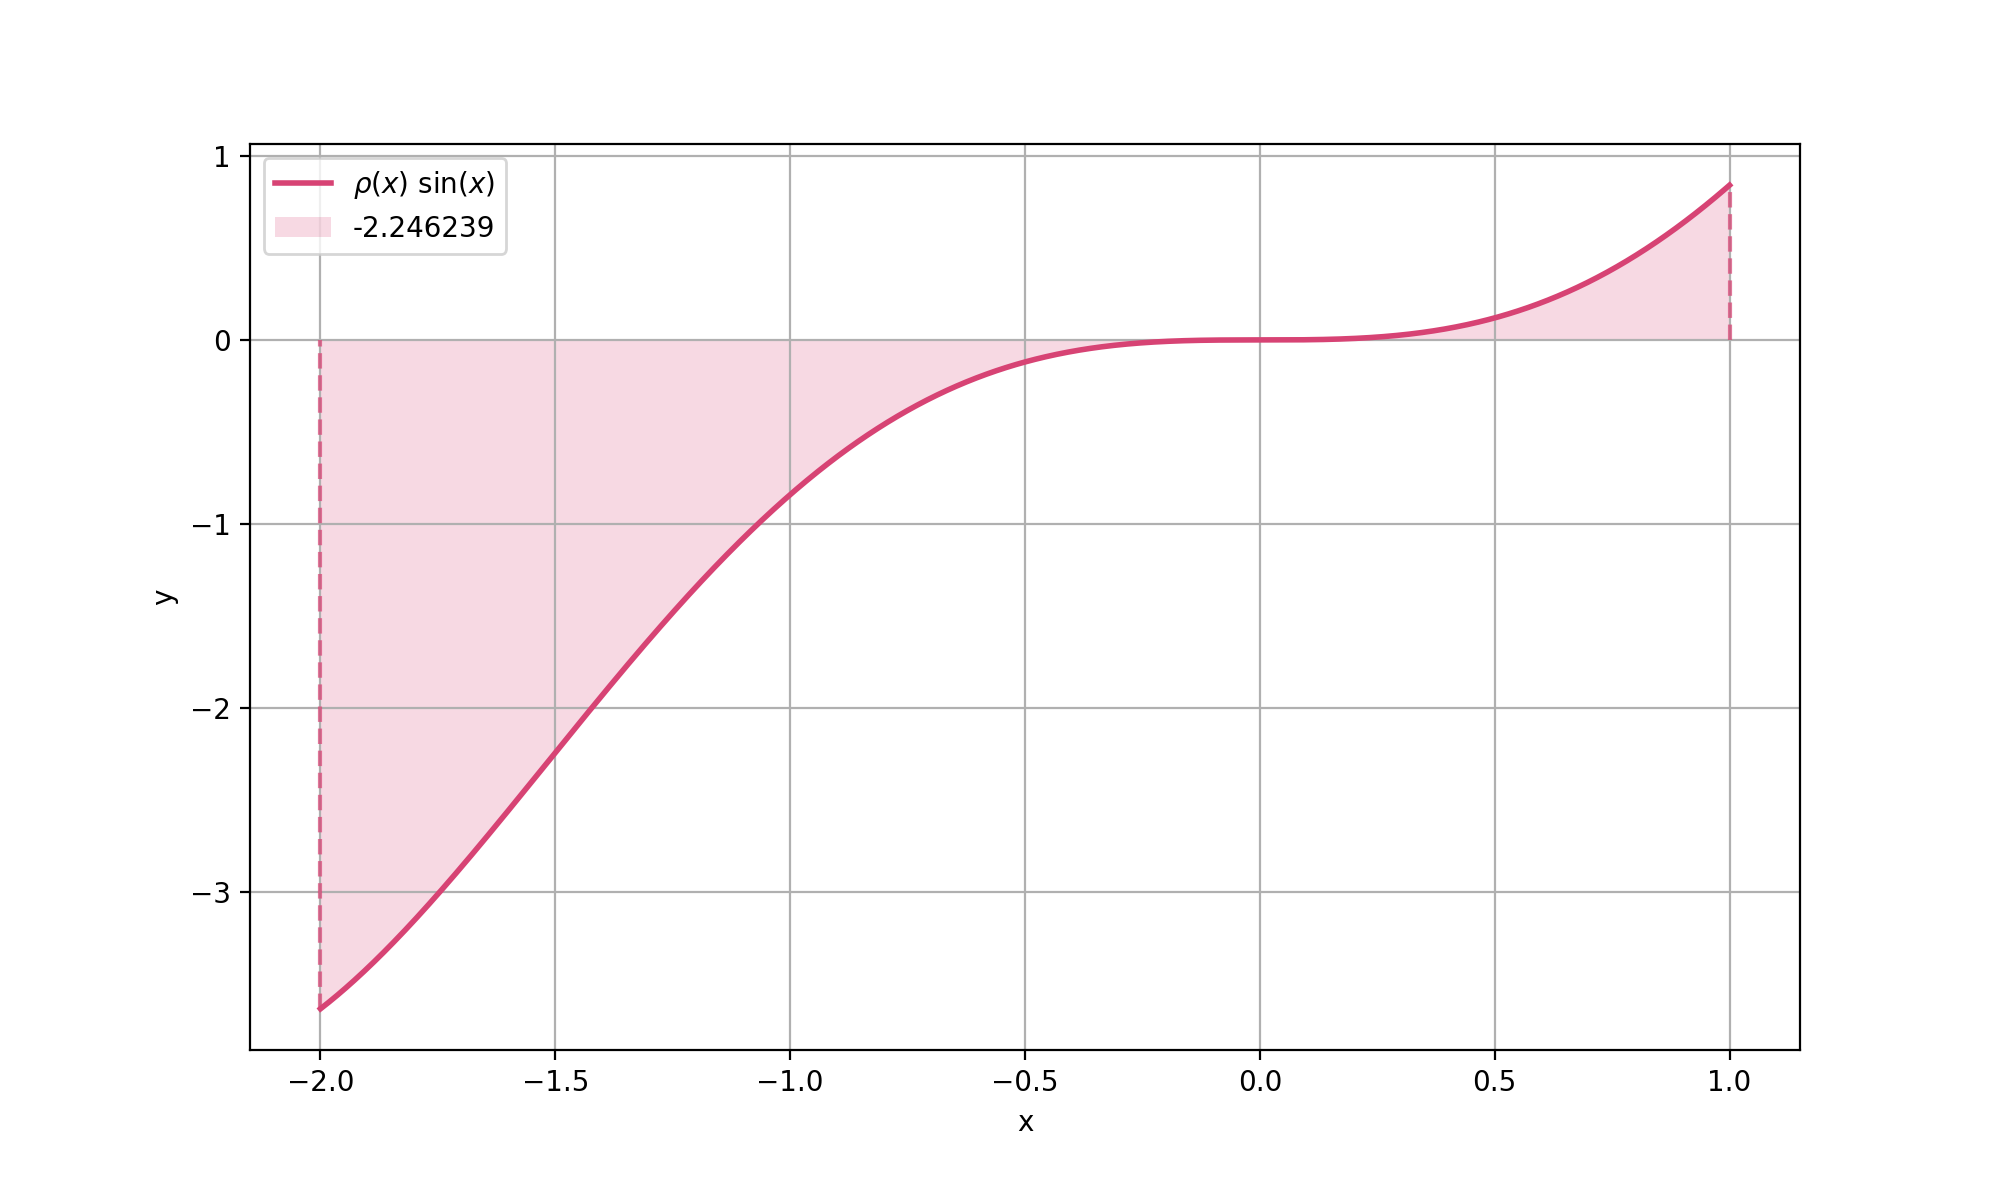

In [111]:
num = 1000
phi = lambda x: rho(x) * f(x)
X = np.linspace(a, b, num)
Y = [phi(x) for x in X]
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
ax.plot(X, Y, color='#d74374', linewidth=2, label=r'$\rho(x)~\sin(x)$')
ax.vlines(a, min(phi(a), 0), max(phi(a), 0), color="#d74374", alpha=0.7, linestyle="--")
ax.vlines(b, min(phi(b), 0), max(phi(b), 0), color="#d74374", alpha=0.7, linestyle="--")
Ox = [0 for _ in X]
ax.fill_between(X, Ox, Y, facecolor='#d74374', alpha=0.2, label=f'{round(Expected, 6)}')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.grid()
ax.legend()

plt.show()